In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import numpy as np


In [3]:
from mnist import load_mnist

# Загрузка данных
train, validation, test = load_mnist()

x_train, y_train = train  # обучающая выборка
x_val, y_val = validation  # валидационная выборка
x_test, y_test = test  # тестовая выборка

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


Примеры из обучающей выборки:


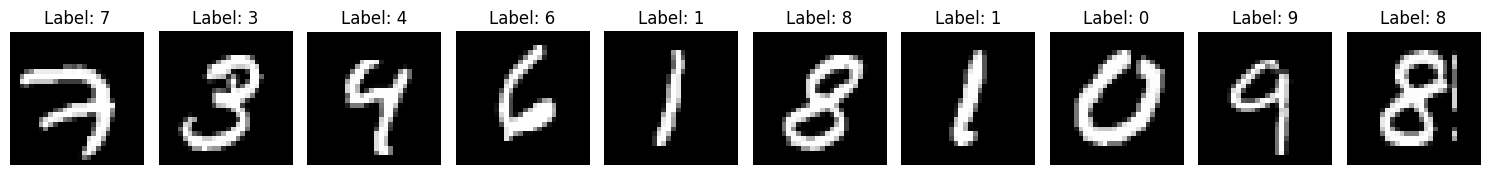

Примеры из тестовой выборки:


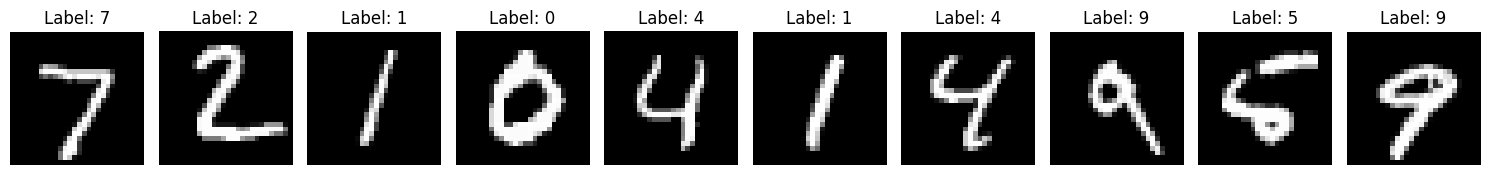

In [4]:
def plot_mnist_samples(x, y, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        image = x[i].reshape(28, 28)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Примеры из обучающей выборки:")
plot_mnist_samples(x_train, y_train)
print("Примеры из тестовой выборки:")
plot_mnist_samples(x_test, y_test)

In [5]:
# Преобразуем данные в numpy массивы
X = np.array(x_train)
Y = np.array(y_train)
X_test_full = np.array(x_test)
Y_test_full = np.array(y_test)

# Разделение данных на обучающую и тестовую выборки для модели
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.2, random_state=42)


In [6]:
# Класс PCA
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X):
        X = np.reshape(X, (-1, 28*28)).astype(np.float32)
        self.X_mean = np.mean(X, axis=0)
        X_centered = X - self.X_mean
        C = np.cov(X_centered, rowvar=False)
        lambd, F = np.linalg.eigh(C)
        sorted_idx = np.argsort(lambd)[::-1]
        lambd = lambd[sorted_idx]
        F = F[:, sorted_idx]
        if self.n_components:
            self.components_ = F[:, :self.n_components]
            self.explained_variance_ = lambd[:self.n_components]
        else:
            self.components_ = F
            self.explained_variance_ = lambd
        return self

    def transform(self, X):
        X = np.reshape(X, (-1, 28*28)).astype(np.float32)
        X_centered = X - self.X_mean
        return X_centered @ self.components_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

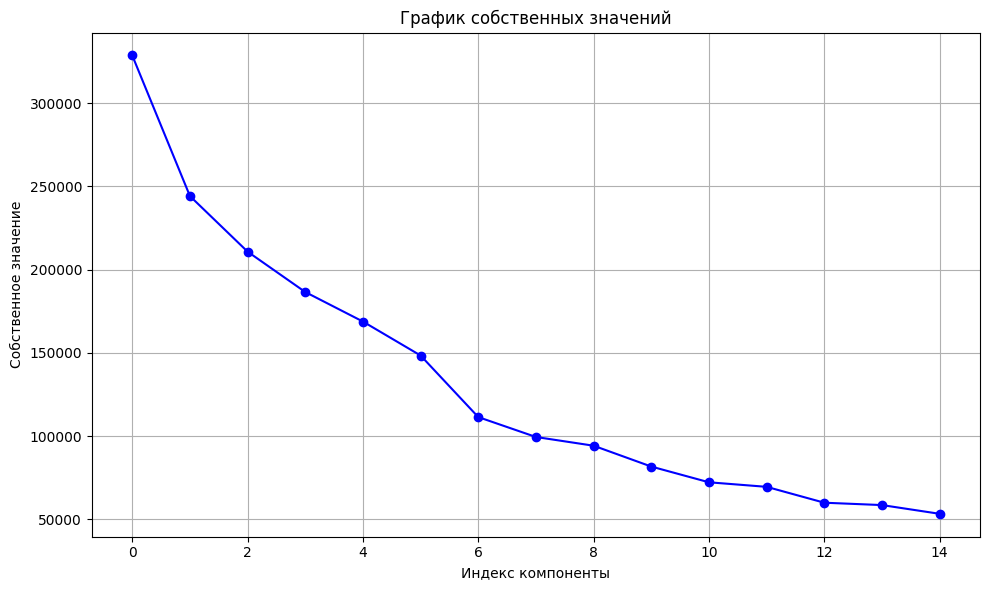

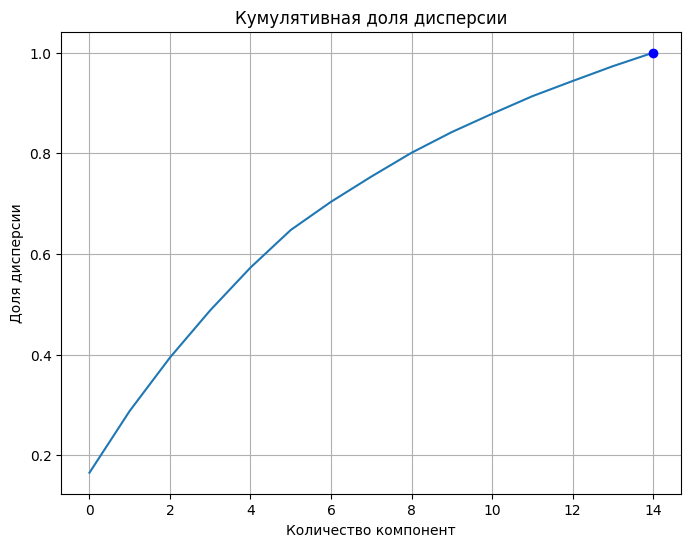

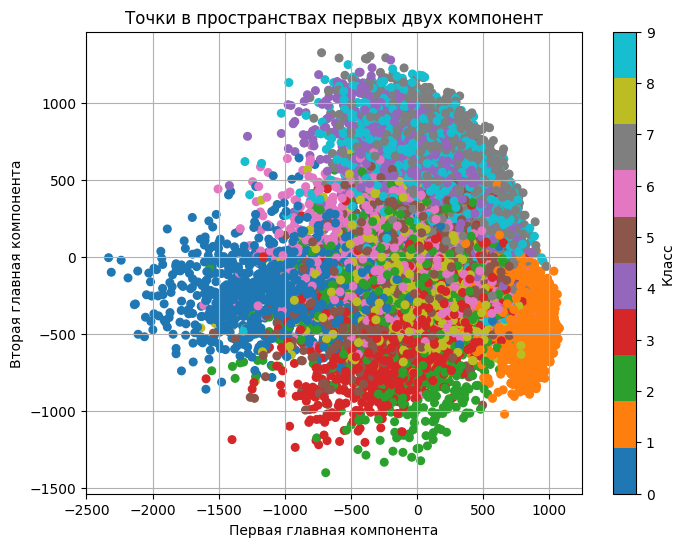

In [7]:
# Обучение PCA
pca = my_PCA(15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Построение графика собственных значений
plt.figure(figsize=(10, 6))
plt.plot(pca.explained_variance_, marker='o', color='b')
plt.title('График собственных значений')
plt.xlabel('Индекс компоненты')
plt.ylabel('Собственное значение')
plt.grid(True)
plt.tight_layout()
plt.show()

# Кумулятивная дисперсия
cumulative_variance = np.cumsum(pca.explained_variance_) / np.sum(pca.explained_variance_)

plt.figure(figsize=(8,6))
plt.plot(cumulative_variance)
plt.xlabel('Количество компонент')
plt.ylabel('Доля дисперсии')
plt.title('Кумулятивная доля дисперсии')
plt.grid()
plt.plot([14], [cumulative_variance[14]], 'bo')
plt.show()

# Доля дисперсии, покрываемая первыми 15 компонентами
#d_15 = np.sum(pca.explained_variance_[:15]) / np.sum(pca.explained_variance_)
#print(f"Доля дисперсии, покрываемая первыми 15 компонентами: {d_15:.2%}")

# Визуализация данных в первых двух главных компонентах
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='tab10', s=30)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Точки в пространствах первых двух компонент')
plt.colorbar(label='Класс')
plt.grid()
plt.show()


In [8]:
# Класс k-NN
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_nearest_idx = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[k_nearest_idx]
            most_common = Counter(neighbor_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

In [9]:
# Обучение и тестирование k-NN
knn = my_kNN(5)
knn.fit(X_train_pca, y_train)
y_pred = knn.predict(X_test_pca)

# Правильный подсчет точности
print(f"Точность на MNIST (после PCA): {accuracy_score(y_test, y_pred):.2%}")

Точность на MNIST (после PCA): 94.26%
